# salt identification problem on kaggle 
   https://www.kaggle.com/c/tgs-salt-identification-challenge

# Background
Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

# Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

In [4]:
# dependency installs
! pip install imageio
! pip install torch
! pip install kaggle
! pip install ipywidgets

    100% |████████████████████████████████| 3.3MB 901kB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59402000 @  0x7fb383c321c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 4.1MB/s 
    100% |████████████████████████████████| 235kB 7.1MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - d

In [0]:
from __future__ import division
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils import data
import imageio
from IPython.display import Image

In [7]:
# upload kaggle API token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mostafa32","key":"75141bafd26a8a39ca341924d9305d5d"}'}

In [8]:
# make sure that the file in the right place
ls -lha kaggle.json 

-rw-r--r-- 1 root root 65 Sep  9 18:34 kaggle.json


In [9]:
# file configurations
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! ls ~/.kaggle

kaggle.json


In [10]:
# download the dataset
! kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 66.0MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 77.7MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 127MB/s]
 96% 156M/163M [00:00<00:00, 157MB/s]
100% 163M/163M [00:00<00:00, 187MB/s]
 63% 24.0M/37.9M [00:00<00:00, 130MB/s]
100% 37.9M/37.9M [00:00<00:00, 155MB/s]


In [12]:
# unzip data
! ls
! unzip train.zip

depths.csv  kaggle.json  sample_data		test.zip   train.zip
images	    masks	 sample_submission.csv	train.csv
Archive:  train.zip
replace images/8d08955cdf.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# write a class to represent our data
class TGSSaltDataset(data.Dataset):
  
  def __init__(self,root_path , file_list):
    self.root_path = root_path
    self.file_list = file_list
    
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self,index):
    
    # image
    file_id = self.file_list[index]
    image_dir = os.path.join(self.root_path,"images")
    image_file = os.path.join(image_dir,file_id+".png")
    
    # label
    file_id = self.file_list[index]
    label_dir = os.path.join(self.root_path,"masks")
    label_file = os.path.join(label_dir,file_id+".png")
    
    # read images
    image = np.array(imageio.imread(image_file),dtype=np.uint8)
    mask = np.array(imageio.imread(label_file),dtype=np.uint8)
    
    return image , mask
    
  

In [0]:
# train image+ mask data
train_mask = pd.read_csv('train.csv')
depth    = pd.read_csv('depths.csv')

train_path ='./'

file_list = list(train_mask['id'].values)

dataset = TGSSaltDataset(train_path,file_list)

In [0]:
# visualize the dataset
def plot2x2Array(iamge,mask):
  f , axarr = plt.subplots(1,2)
  axarr[0].imshow(iamge)
  axarr[1].imshow(mask)
  
  axarr[0].grid()
  axarr[1].grid()
  
  axarr[0].set_title('image')
  axarr[1].set_title('mask')
  

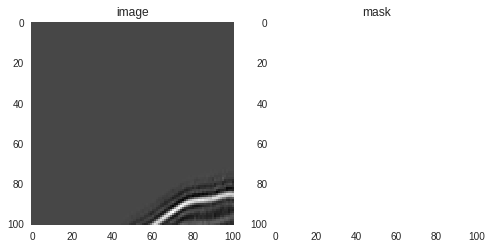

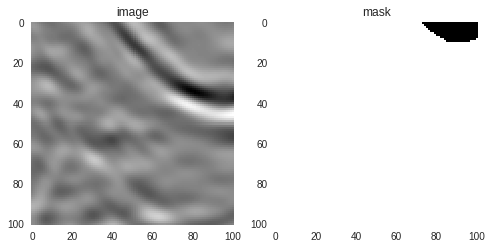

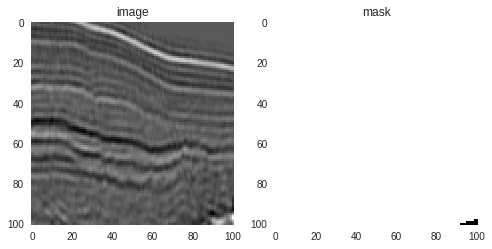

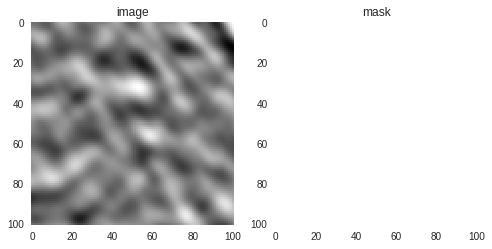

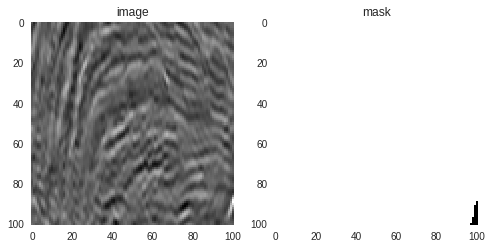

In [17]:
for i in range(5):
  # pick image and mask rendomly
  image,mask= dataset[np.random.randint(0,len(dataset))]
  plot2x2Array(image,mask)

Text(0.5,1,'depth dist')

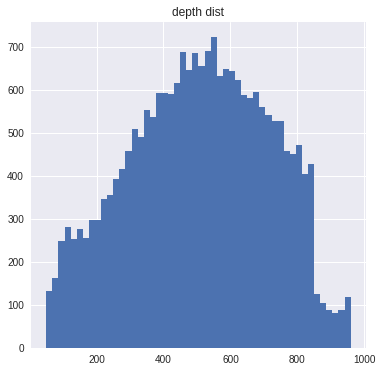

In [18]:
# visualize depths
plt.figure(figsize=(6,6))
plt.hist(depth['z'],bins=50)
plt.title('depth dist')

In [0]:
# rle to mask
def rleToMask(rleSting,height,width):
  rows ,cols = height,width
  
  try:
    #get rle numbers
    rleNumbers = [int(numberString) for numberString in rleSting.split(' ')]
    
    #get pairs
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    #create an image 
    img = np.zeros(rows*cols , dtype=np.uint8)
    # for each pair
    for index,length in rlePairs:
      index -= 1
      img[index:index+length]=255
      
    img = img.reshape(cols,rows)
    img = img.T
    
  except:
    img = np.zeros((cols,rows))
  return img


In [0]:
# measure how salty an image is
def salt_proportion(imgArray):
  try:
    unique,counts  = np.unique(imgArray,return_counts=True)
    return counts[1]/10201 # because each image is 101*101 = 10,201
  except:
     return 0.0

In [21]:
train_mask.head(4)

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...


In [0]:
# convert rle mask using rleToMask function 
train_mask['mask']  = train_mask['rle_mask'].apply(lambda x:rleToMask(x,101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x:salt_proportion(x))

In [23]:
merged = train_mask.merge(depth , how='left')
merged.head(4)

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727


Text(0.5,1,'Proportion of salt v. depth')

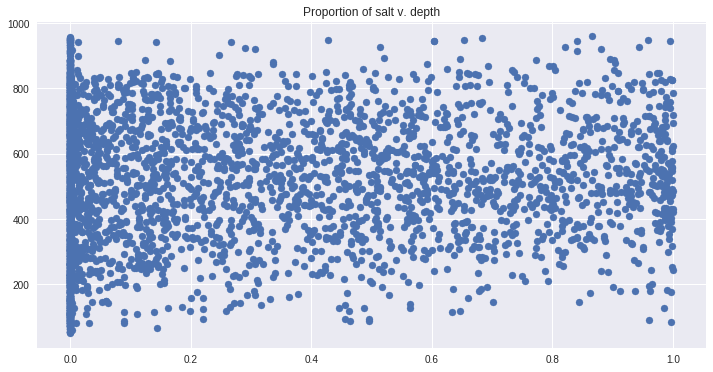

In [24]:
# how salt_proportion is correlated to depth
plt.figure(figsize=(12,6))
plt.scatter(merged['salt_proportion'],merged['z'])
plt.title('Proportion of salt v. depth')

In [25]:
print("correlation is ",np.corrcoef(merged['salt_proportion'],merged['z'])[0,1])

correlation is  0.10361580365557428


#       now let's go to UNet

# why use U-Net ?

- U-NET is considered one of standard architectures for image classification tasks, when we need not only to segment the whole image by its class, but also to segment areas of image by class, i.e. produce a mask that will separate image into several classes. -its architecture is input image size agnostic since it does not contain fully connected layers

- Because of many layers takes significant amount of time to train;
- U-Net is designed like an auto-encoder.
- It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.
- However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole.
- For each pixel in the original image, it asks the question: “To which class does this pixel belong?
- This flexibility allows U-Net to predict different parts of the seismic image (salt, not salt) simultaneously.

- U-Net passes the feature maps from each level of the contracting path over to the analogous level in the expanding path.

- These are similar to residual connections in a ResNet type model, and allow the classifier to consider features at various scales and complexities to make its decision.



In [77]:
from google.colab import files
files.upload()

Saving unet_2.png to unet_2.png


{'unet_2.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x7f\x00\x00\x02N\x08\x06\x00\x00\x00\xc6ha\xf3\x00\x00\x80\x00IDATx\xda\xec\x9d\x05|\xd6\xd7\xf5\xff\xa9\xe3\xee\xae-T)\xa5\xa5\xee:\xf9m\xeb\xd6u\xebZ,\x84@\x08!8u\x97\xff|\xeb\xb6\xbaPJ\x15\n\xc5\xa5P\x83\xba\xe0\x10\xac@a-\x0eq{r\xfe\xf7}\xbf\xcfyr\xf3\xed\x13H\x05\x9a,\xf7\xf0\xba|\xf3|]\xee=\xf7s\xbc\x9ax\xf2t\x88\xa9y\xf3\xe6vYXX(yyy\xa5\xb6\x15\x17\x17\xfb\x17\xe4\xc9\x93\'O\x87\x98\xe0\xb5\xda\\ryr~~~\xec\xef\xec\xecl\xcf\x9f\xff\x87\xa9\x9a\x7f\x05\x9e\x0e5u\xe9\xd2\xc5.ssscL(\x12\x89|\x83\xd9x\xf2\xe4\xc9\x93\xa7\xc3\x0b\xfe\xa0\xa2\xa2\xa2\xd8\xdfYYY\xfeey\xf0\xe7\xc9\xd3\xf7\xa7\xf6\xed\xdb[\xe9R%L$J\xfd[A\xa0\'O\x9e<y:|@\x10\xde\xeb\x82\xbe\x9c\x9c\x9c\xd86w\xbd\'\x0f\xfe<y\xfaN\xd4\xbauk\xab\xe1\xc3\xec\xeb%KO\x9e<y:\xbc@/\xde\xba\x82\x82\x02+\x84?\xf7\xdcsv\x1d\xbf\x95\x94W{\xe1\xdc\x83?O\x9e\xbe3u\xee\xdc9\xc6\\`:\xaa\xf5SI\xd3\x93\'O\x9e<\x1d>\xf0\x07\xa8C \x87\x07\xb7j\xd5\xcaZc \xef\x86\xe3\xc1\x9f\'O?\

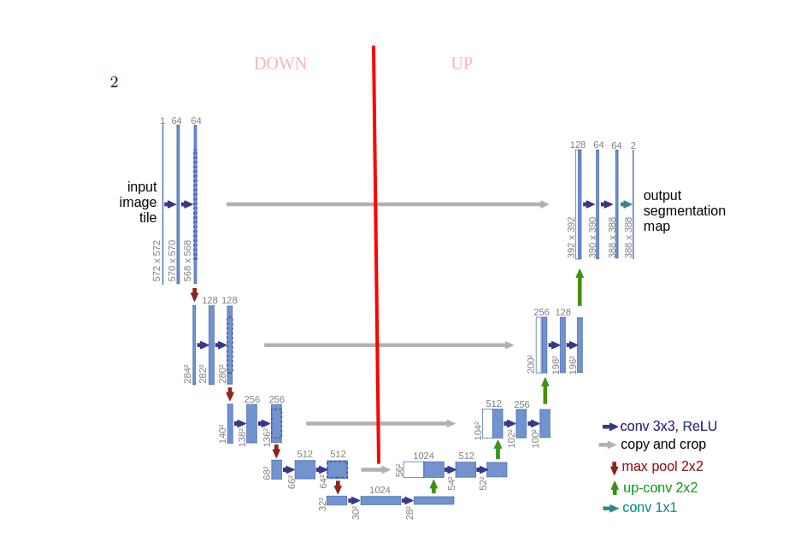

In [82]:
Image('unet_1.png')

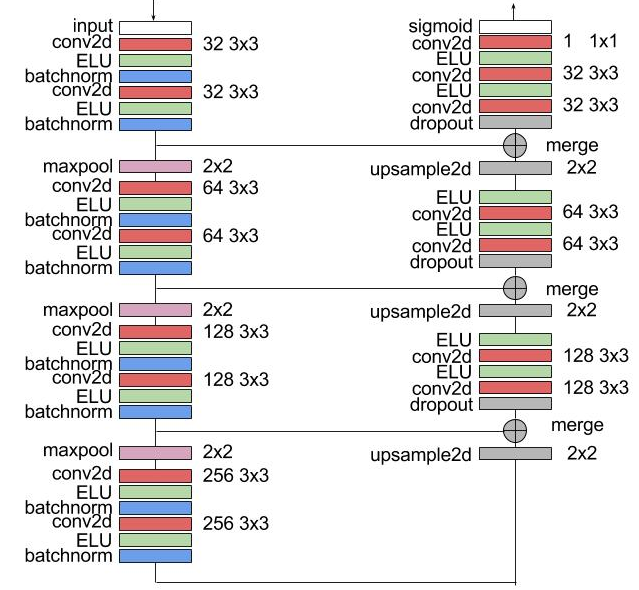

In [83]:
Image('unet_2.png')

In [26]:
from keras.models import Model , load_model
from keras.layers import Input
from keras.layers.core import Lambda , RepeatVector , Reshape
from keras.layers.convolutional import Conv2D , Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth


In [34]:
# build U-Net model

input_image = Input((im_width,im_height,im_chan),name='img')
input_features = Input((n_features,),name='feat')

c1 = Conv2D(8,(3,3),activation='relu',padding='same')(input_image)
c1 = Conv2D(8,(3,3),activation='relu',padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)


c2 = Conv2D(16,(3,3),activation='relu',padding='same')(p1)
c2 = Conv2D(16,(3,3),activation='relu',padding='same')(c2)
p2 = MaxPooling2D(2,2)(c2)

c3 = Conv2D(32,(3,3),activation='relu',padding='same')(p2)
c3 = Conv2D(32,(3,3),activation='relu',padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)


c4 = Conv2D(64,(3,3),activation='relu',padding='same')(p3)
c4 = Conv2D(64,(3,3),activation='relu',padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

# join features information in the depthest layer 
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8,8,n_features))(f_repeat)
p4_feat = concatenate([p4,f_conv],-1)


c5 = Conv2D(128,(3,3),activation='relu',padding='same')(p4_feat)
u6 = Conv2D(128,(3,3),activation='relu',padding='same')(c5)

u6 = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c5)

# skip connections
u6 = concatenate([u6,c4])
c6 = Conv2D(64,(3,3),activation ='relu',padding='same')(u6)
c6 = Conv2D(64,(3,3),activation ='relu',padding='same')(c6)

u7 = Conv2DTranspose(32,(3,3),strides=(2,2),padding='same')(c6)
u7 = concatenate([u7,c3])
c7 = Conv2D(32,(3,3),activation='relu',padding='same')(u7)
c7 = Conv2D(32,(3,3),activation='relu',padding='same')(c7)

u8 = Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c7)
u8 = concatenate([u8,c2])
c8 = Conv2D(16,(3,3),activation='relu',padding='same')(u8)
c8 = Conv2D(16,(3,3),activation='relu',padding='same')(c8)

u9 = Conv2DTranspose(8,(2,2),strides=(2,2),padding='same')(c8)
u9 = concatenate([u9,c1],axis=3)
c9 = Conv2D(8,(3,3),activation='relu',padding='same')(u9)
c9 = Conv2D(8,(3,3),activation='relu',padding='same')(c9)


outputs = Conv2D(1,(1,1),activation='sigmoid')(c9)

model= Model(inputs=[input_image, input_features],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 128, 128, 8)  584         conv2d_86[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_87[0][0]                  
__________________________________________________________________________________________________
conv2d_88 

In [36]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 4000/4000 [00:22<00:00, 181.56it/s]

Done!


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [0]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - 283s 83ms/step - loss: 0.5882 - val_loss: 0.5687

Epoch 00001: val_loss improved from inf to 0.56867, saving model to model-tgs-salt-1.h5
Epoch 2/50
3400/3400 [==============================] - 280s 82ms/step - loss: 0.5235 - val_loss: 0.4561

Epoch 00002: val_loss improved from 0.56867 to 0.45605, saving model to model-tgs-salt-1.h5
Epoch 3/50
3400/3400 [==============================] - 281s 83ms/step - loss: 0.4105 - val_loss: 0.3435

Epoch 00003: val_loss improved from 0.45605 to 0.34351, saving model to model-tgs-salt-1.h5
Epoch 4/50
3400/3400 [==============================] - 281s 83ms/step - loss: 0.3354 - val_loss: 0.3362

Epoch 00004: val_loss improved from 0.34351 to 0.33618, saving model to model-tgs-salt-1.h5
Epoch 5/50
3400/3400 [==============================] - 281s 83ms/step - loss: 0.2979 - val_loss: 0.2592

Epoch 00005: val_loss improved from 0.33618 to 0.25915, sav